In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import os

# Test 1 - Increase number of videos matched daily by a user
with the new recommendation
- Unit to measure : % increase of number videos watched daily
- Variant A : Default recommendation
- Variant B : New recommendation
- Allocation : UserID

In [155]:
sample_per_day = 50_000 # person
num_days = 21
C_level = 0.98 # Target confidence level

In [156]:
# Generate variant data
samples = {'A': [], 'B': []}
for n in range(num_days):
    sample_size = int(sample_per_day // 2)
    # sample below : num videos watched by a user given 10 shown
    A = np.random.binomial(n=10, p=0.1, size=sample_size)
    B = np.random.binomial(n=10, p=0.1053, size=sample_size)
    samples['A'] = np.concatenate([samples['A'], A])
    samples['B'] = np.concatenate([samples['B'], B])
len(samples['A']), len(samples['B'])

(525000, 525000)

## Bootstrap method

In [157]:
# Bootstrap
def bootstrap(samples, N=5000, K=2500, cap=-1, measure=np.mean):
    def draw(samples, K):
        A = np.random.choice(samples['A'][:cap], size=K//2, replace=True)
        B = np.random.choice(samples['B'][:cap], size=K//2, replace=True)
        a = measure(A)
        b = measure(B)
        return a,b

    bs = [draw(samples, K) for n in range(N)]
    return bs

In [158]:
bs = bootstrap(samples, N=5000, K=2500)

### Plot of bootstrap samples
A v B

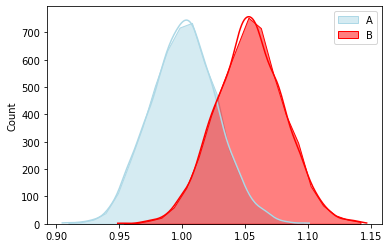

In [159]:
A, B = zip(*bs)
sns.histplot(data=A, color='lightblue', label='A', kde=True, bins=20, element='poly')
sns.histplot(data=B, color='red', label='B', kde=True, bins=20, element='poly')
plt.legend()

### Generate daily bootstrap samples
Simulate A/B test daily run

In [160]:
dailyrun = [bootstrap(samples, N=5000, K=2500, cap=d*sample_per_day) \
            for d in range(1,num_days+1)]

### Evaluate significance level over time

![image](ab.png)

In [161]:
def confidence_interval(P, level):
    z = scipy.stats.norm.ppf(level) # probability => z score (inverse CDF)
    margin_err = z * np.std(P) / np.sqrt(len(P))
    return np.mean(P), margin_err

def significance(bs, level=0.95):
    # find confidence interval of A
    a, b = zip(*bs)
    mean_a, margin_err = confidence_interval(a, level)
    upperbound = mean_a + margin_err
    
    # find area of B, start from upperbound of A towards right tail
    zb = (upperbound - np.mean(b)) / np.std(b)
    sig = 1 - scipy.stats.norm.cdf(zb)
    return sig

In [162]:
dailysig = [significance(bs, level=C_level) for bs in dailyrun]

/Users/pataoengineer/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


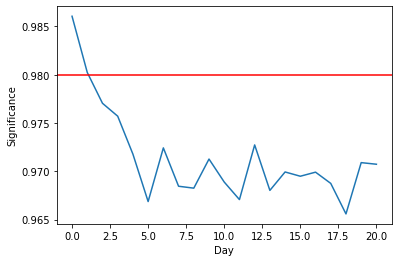

In [163]:
ax = sns.lineplot(np.arange(len(dailysig)), dailysig)
ax.set(ylabel='Significance', xlabel='Day')
ax.axhline(C_level, color='red')

# Test 2 - (High variance) Sale compaigns
- A : Default pricing models
- B : Added on campaigns

In [142]:
sample_per_day = 200 # person
num_days = 15
C_level = 0.9 # Target confidence level

In [149]:
# Generate variant data
samples = {'A': [], 'B': []}
for n in range(num_days):
    sample_size = int(sample_per_day // 2)
    # sample below : margin revenues
    A = np.random.normal(loc=4, scale=25, size=sample_size)
    B = np.random.normal(loc=5.1, scale=50, size=sample_size)
    samples['A'] = np.concatenate([samples['A'], A])
    samples['B'] = np.concatenate([samples['B'], B])
len(samples['A']), len(samples['B'])

(1500, 1500)

## Bootstrap

In [150]:
bs = bootstrap(samples, N=5000, K=3000)

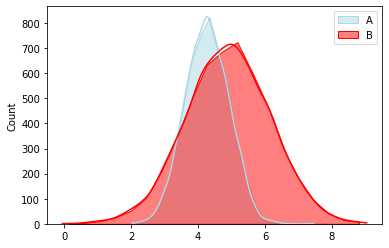

In [151]:
A, B = zip(*bs)
sns.histplot(data=A, color='lightblue', label='A', kde=True, bins=20, element='poly')
sns.histplot(data=B, color='red', label='B', kde=True, bins=20, element='poly')
plt.legend()

## Generate daily run
Simulate A/B daily run

In [152]:
dailyrun = [bootstrap(samples, N=4000, K=5000, cap=d*sample_per_day) \
            for d in range(1,num_days+1)]

## Measure significance over daily runs
and plot daily observation

In [153]:
dailysig = [significance(bs, level=C_level) for bs in dailyrun]

/Users/pataoengineer/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


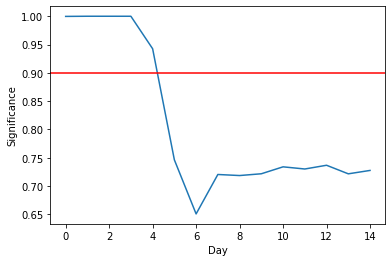

In [154]:
ax = sns.lineplot(np.arange(len(dailysig)), dailysig)
ax.set(ylabel='Significance', xlabel='Day')
ax.axhline(C_level, color='red')